In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
# read data
df = pd.read_csv('all_responses.csv')
df = df[df.columns[1:]]
df.head(1)

,total_time,llm,db,sentence_transformer,chunk_size,overlaps,embedding_time,embedding_memory,db_indexing_time,db_memory,q1,q2,q3,q4,q5,answer_quality
0,49.577093,llama3.2:3b,redis,sentence-transformers/all-MiniLM-L6-v2,300,25,1.020187,0.386653,3.409584,0.546808,The CAP theorem states that it is impossible f...,"In a B+ tree, data is organized in a self-bala...",The key advantages of using NoSQL databases ov...,You would prefer using a B+ tree over a hash i...,To retrieve all documents where the nested fie...,7


In [3]:
df.groupby(by='db')['db_indexing_time'].median()

db
chroma    0.537190
faiss     0.463979
redis     1.035965
Name: db_indexing_time, dtype: float64

In [4]:
sns.set(style="whitegrid")

df['transformer_short'] = df['sentence_transformer'].apply(lambda x: x.split("/")[-1])
df['pipeline'] = df['llm'] + ' | ' + df['db'] + ' | ' + df['transformer_short']

pivot_embed = df.pivot_table(index='sentence_transformer', columns='db', values='embedding_memory')
pivot_db = df.pivot_table(index='sentence_transformer', columns='db', values='db_memory')

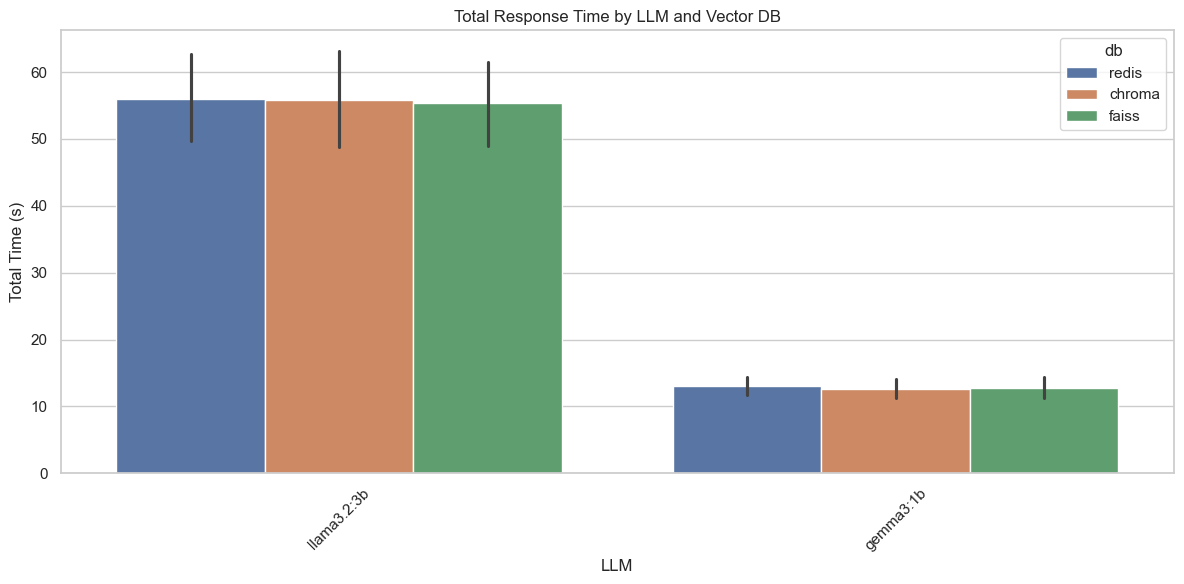

In [5]:
plt.figure(figsize=(12, 6))
sns.barplot(x='llm', y='total_time', hue='db', data=df)
plt.title('Total Response Time by LLM and Vector DB')
plt.ylabel('Total Time (s)')
plt.xlabel('LLM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

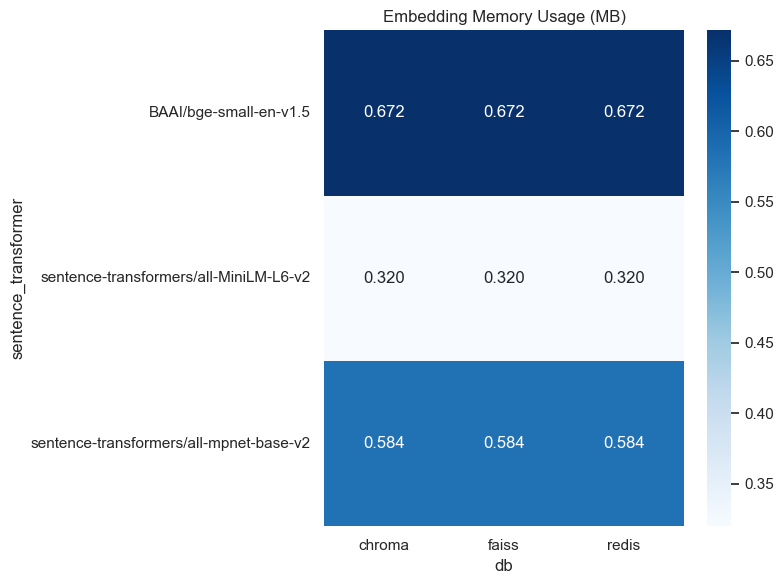

In [6]:
# Embedding Memory Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_embed, annot=True, fmt=".3f", cmap="Blues")
plt.title('Embedding Memory Usage (MB)')
plt.tight_layout()
plt.show()

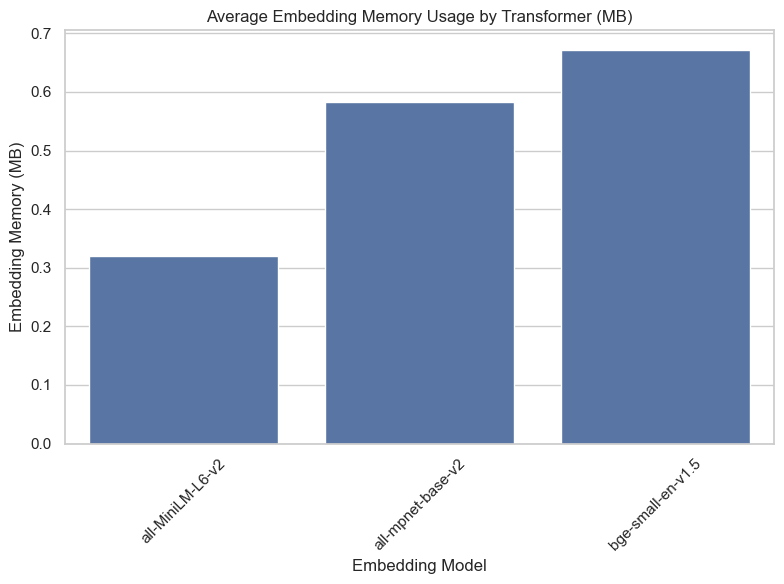

In [7]:
df['transformer_short'] = df['sentence_transformer'].apply(lambda x: x.split("/")[-1])
mean_embedding_memory_short = df.groupby('transformer_short')['embedding_memory'].mean().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='transformer_short', y='embedding_memory', data=mean_embedding_memory_short)
plt.title('Average Embedding Memory Usage by Transformer (MB)')
plt.ylabel('Embedding Memory (MB)')
plt.xlabel('Embedding Model')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

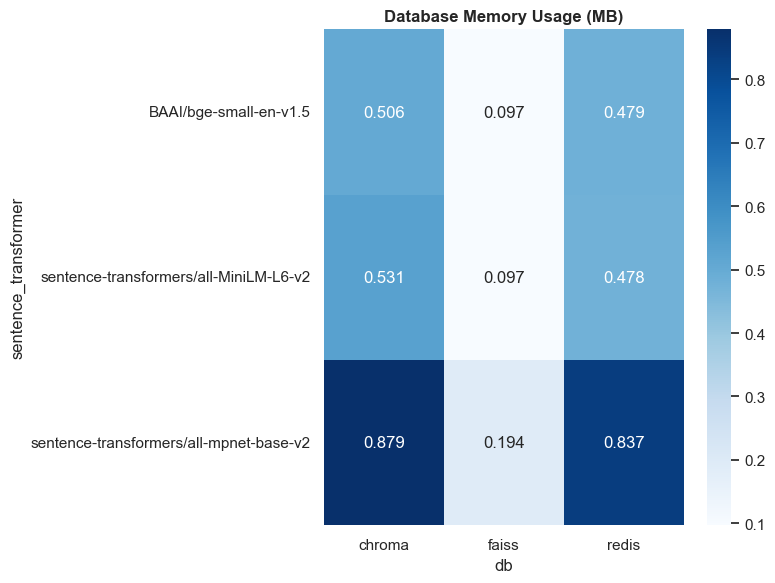

In [8]:
# Database Memory Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_db, annot=True, fmt=".3f", cmap="Blues")
plt.title('Database Memory Usage (MB)', fontweight='bold')
plt.tight_layout()
plt.savefig('db_transformer_dbmemoryusage.png', transparent=True)
plt.show()

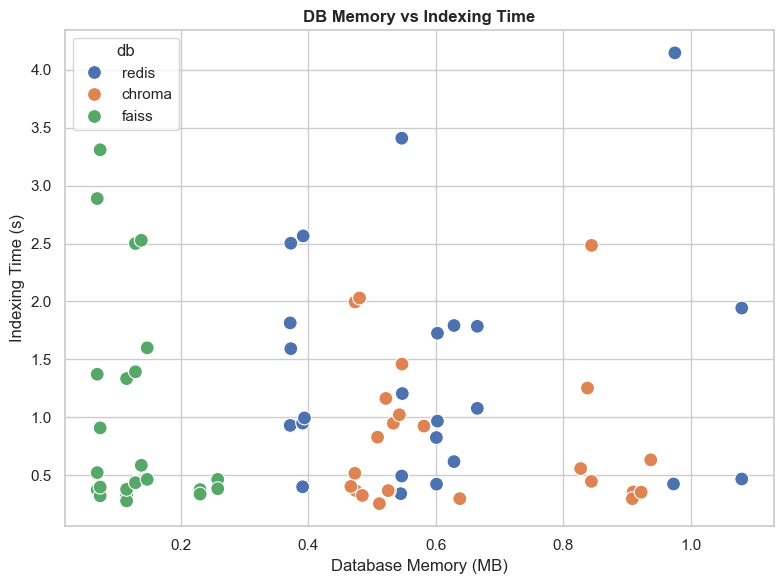

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='db_memory', y='db_indexing_time', hue='db', s=100, data=df)
plt.title('DB Memory vs Indexing Time', fontweight='bold')
plt.xlabel('Database Memory (MB)')
plt.ylabel('Indexing Time (s)')
plt.grid(True)
plt.tight_layout()
plt.savefig('db_memory_vs_indextime.png', transparent=True)
plt.show()

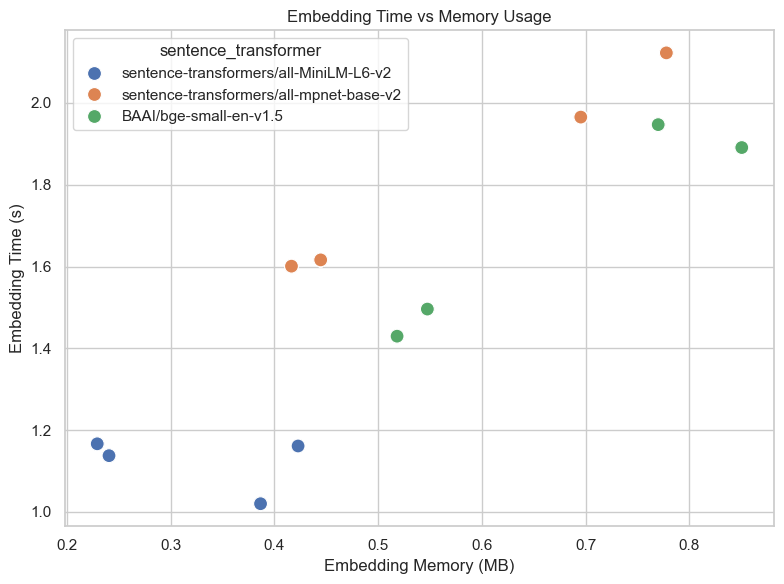

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='embedding_memory', y='embedding_time', hue='sentence_transformer', s=100, data=df)
plt.title('Embedding Time vs Memory Usage')
plt.xlabel('Embedding Memory (MB)')
plt.ylabel('Embedding Time (s)')
plt.grid(True)
plt.tight_layout()
plt.show()

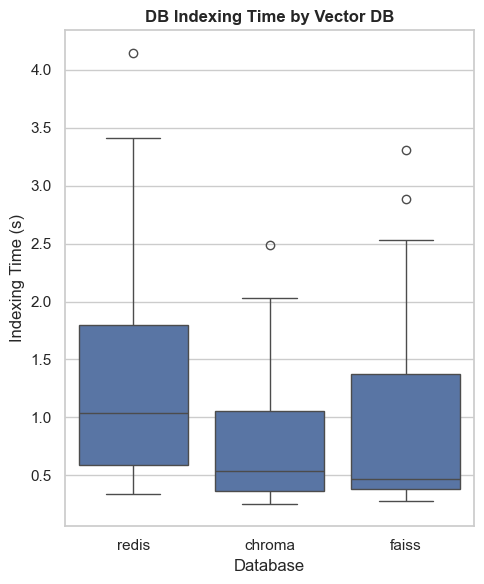

In [11]:
plt.figure(figsize=(5, 6))
sns.boxplot(data=df, x='db', y='db_indexing_time')
plt.title('DB Indexing Time by Vector DB', fontweight='bold')
plt.ylabel('Indexing Time (s)')
plt.xlabel('Database')
plt.tight_layout()
plt.savefig('db_indexing_time.png', transparent=True)
plt.show()

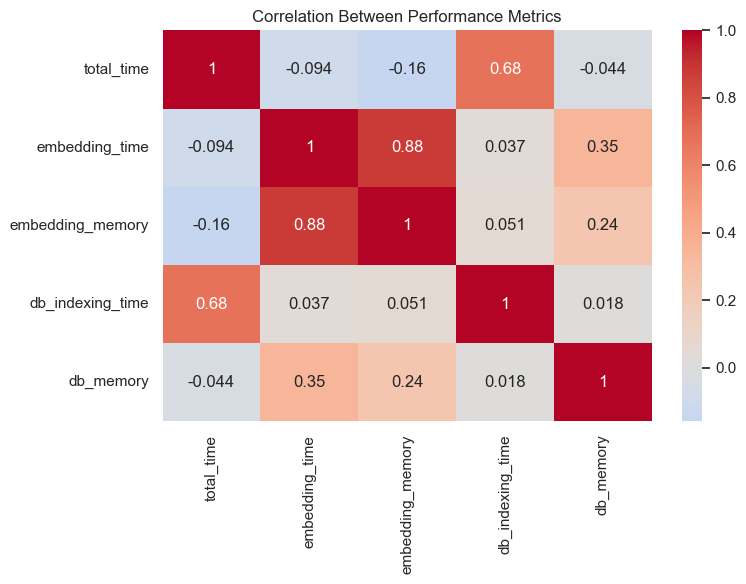

In [12]:
corr = df[['total_time', 'embedding_time', 'embedding_memory', 'db_indexing_time', 'db_memory']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Performance Metrics')
plt.tight_layout()
plt.show()

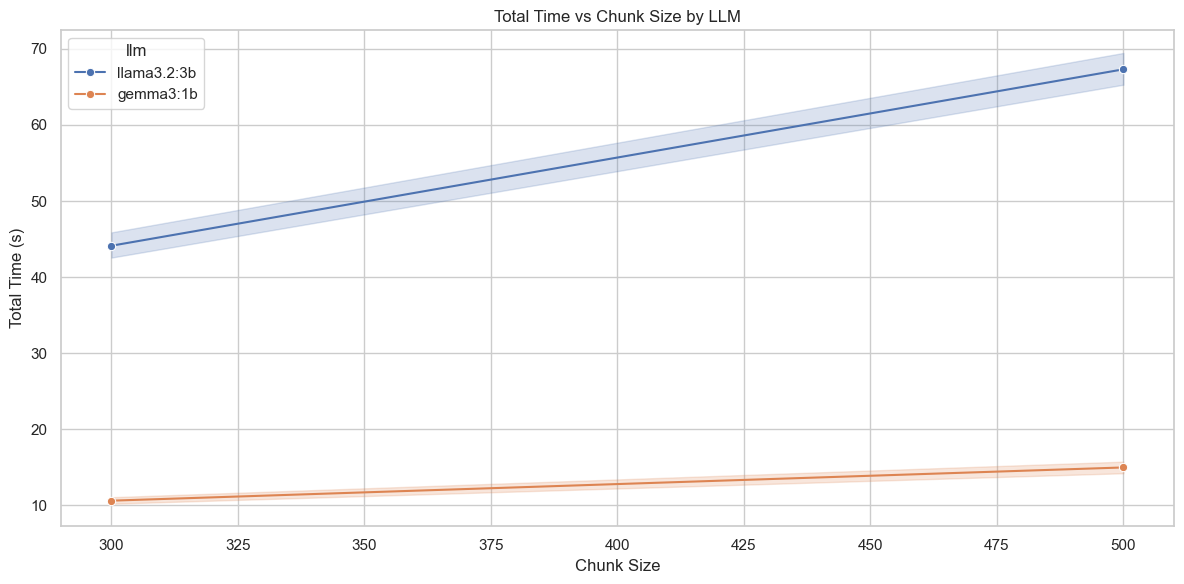

In [13]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='chunk_size', y='total_time', hue='llm', marker="o")
plt.title('Total Time vs Chunk Size by LLM')
plt.ylabel('Total Time (s)')
plt.xlabel('Chunk Size')
plt.grid(True)
plt.tight_layout()
plt.show()

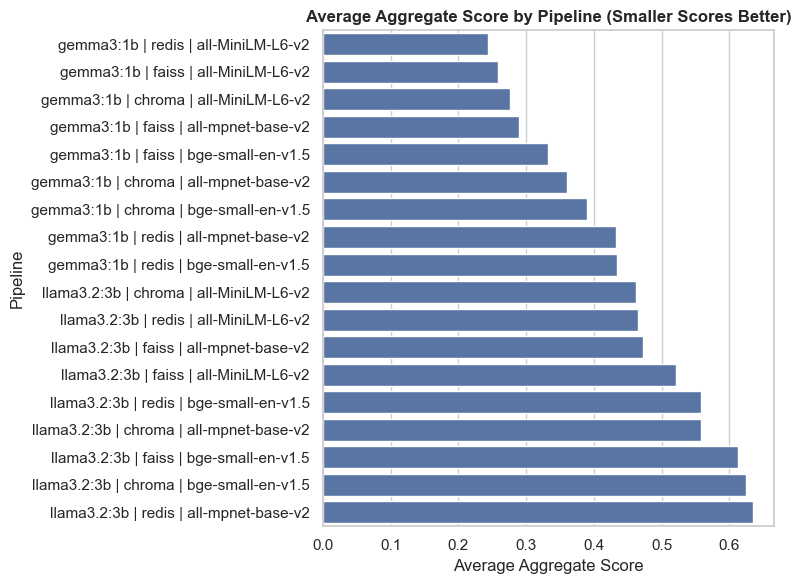

In [14]:
weights = {
    'total_time': 0.35,
    'embedding_time': 0.025,
    'db_indexing_time': 0.025,
    'embedding_memory': 0.1,
    'db_memory': 0.05,
    'answer_quality': 0.45
}

scaler = MinMaxScaler()
norm_cols = list(weights.keys())
normalized_values = scaler.fit_transform(df[norm_cols])
normalized_df = pd.DataFrame(normalized_values, columns=[f"norm_{k}" for k in weights.keys()])

normalized_df['norm_answer_quality_inverted'] = 1 - normalized_df['norm_answer_quality']
df['aggregate_score'] = (
    normalized_df["norm_total_time"] * weights["total_time"] +
    normalized_df["norm_embedding_time"] * weights["embedding_time"] +
    normalized_df["norm_db_indexing_time"] * weights["db_indexing_time"] +
    normalized_df["norm_embedding_memory"] * weights["embedding_memory"] +
    normalized_df["norm_db_memory"] * weights["db_memory"] +
    normalized_df["norm_answer_quality_inverted"] * weights["answer_quality"]
)
avg_scores = df.groupby('pipeline')['aggregate_score'].mean().reset_index().sort_values(by='aggregate_score')

plt.figure(figsize=(8, 6))
sns.barplot(data=avg_scores, y='pipeline', x='aggregate_score')
plt.title('Average Aggregate Score by Pipeline (Smaller Scores Better)', fontweight='bold')
plt.xlabel('Average Aggregate Score')
plt.ylabel('Pipeline')
plt.tight_layout()
plt.savefig('db_aggregate_scoring_horizontal.png', transparent=True)
plt.show()

In [15]:
df.groupby(by=['transformer_short','chunk_size', 'overlaps'])['answer_quality'].mean()

transformer_short  chunk_size  overlaps
all-MiniLM-L6-v2   300         25          6.500000
                               50          6.666667
                   500         25          6.500000
                               50          6.666667
all-mpnet-base-v2  300         25          6.000000
                               50          6.666667
                   500         25          6.500000
                               50          7.000000
bge-small-en-v1.5  300         25          5.833333
                               50          6.000000
                   500         25          7.000000
                               50          6.500000
Name: answer_quality, dtype: float64